In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 赛道标签清洗函数
def clean_label(label):
    # 1. 先去掉前置题号
    label = re.sub(r'^\d+、', '', label)
    # 2. 如果有“—”或“-”，优先取其后的内容
    if '—' in label:
        label = label.split('—', 1)[1]
    elif '-' in label:
        label = label.split('-', 1)[1]
    # 3. 特殊情况：如果还剩下“兴趣程度如何”这类题干，尝试提取后面的“编号.名称”
    if "兴趣程度" in label or "度如何" in label or "每个赛道" in label:
        m = re.search(r'[\d]+[\.、．]\s*([^\n，。？]*)', label)
        if m:
            label = m.group(1)
    # 4. 再统一去掉开头编号（如"2."、"10."、"15."、“2、”等，中英文点号、顿号、冒号、全角冒号、空格）
    label = re.sub(r'^[\d]+[\.、．:：、\s]*', '', label)
    # 5. 去除括号及内容
    label = re.sub(r'（.*?）', '', label)
    label = re.sub(r'\(.*?\)', '', label)
    # 6. 去除剩余左右空格
    return label.strip()
    
# 数据读取与整理
data = pd.read_excel(r"D:\大一\课程\概率论\大作业\大作业数据.xlsx")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
data.columns = [re.sub(r'\s+', '', col) for col in data.columns]

def extract_numeric(df, cols):
    return df[cols].apply(lambda s: pd.to_numeric(s.astype(str).str.extract(r'(\d+)')[0], errors='coerce'))

interest_cols = [c for c in data.columns if c.startswith('11、')]
difficulty_cols = [c for c in data.columns if c.startswith('12、')]
socval_cols = [c for c in data.columns if c.startswith('14、')]
willing_cols = [c for c in data.columns if c.startswith('17、')]
sex_col = '1、你的性别是'
coding_col = '4、你觉得与科创实验班其他同学相比，你目前（大一下学期）的编程能力'
sports_col = '8、你平均每周花多少时间在运动锻炼上？'
games_col = '9、你平均每周花多少时间在电子游戏上（含手机游戏、电脑游戏、主机游戏等）'
grade_col = '2、你在进入科创实验班之前的专业'

interest_scores = extract_numeric(data, interest_cols)
difficulty_scores = extract_numeric(data, difficulty_cols)
socval_scores = extract_numeric(data, socval_cols)
willing_scores = extract_numeric(data, willing_cols)


1. 各赛道兴趣均值
各赛道兴趣均值（最大似然估计）:
移动机器人相关: 均值=3.90
元宇宙: 均值=3.85
消费电子: 均值=3.85
健康科技: 均值=3.82
人形机器人: 均值=3.79
智能家居: 均值=3.79
户外休闲: 均值=3.59
工业机器人相关: 均值=3.46
医疗干预: 均值=3.38
养老: 均值=3.33
兴趣爱好: 均值=3.31
医疗检测: 均值=3.28
宠物经济: 均值=3.23
竞技运动: 均值=3.08
助残: 均值=2.92
教育培训: 均值=2.74

结论：
问卷数据显示，对“移动机器人相关”赛道存在普遍偏好（平均兴趣分最高，为3.90）。


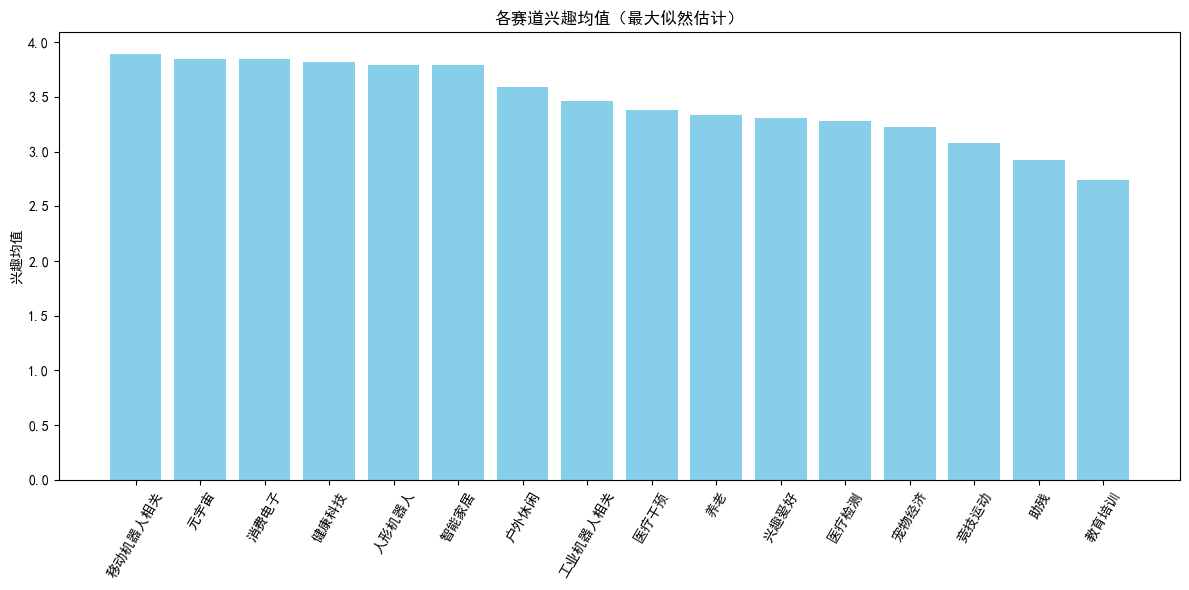

In [45]:
# 1. 各赛道兴趣均值（均值最大似然法估计）
print("\n1. 各赛道兴趣均值")

# 最大似然估计各赛道的兴趣均值
mean_results = {}
for col in interest_cols:
    vals = interest_scores[col].dropna()
    if len(vals) == 0:
        continue
    mu, std = stats.norm.fit(vals)
    mean_results[col] = mu

# 按均值排序，输出
sorted_means = sorted(mean_results.items(), key=lambda x: x[1], reverse=True)
print("各赛道兴趣均值（最大似然估计）:")
for col, mu in sorted_means:
    print(f"{clean_label(col)}: 均值={mu:.2f}")

# 找出偏好最高的赛道
top_label, top_mean = clean_label(sorted_means[0][0]), sorted_means[0][1]
print("\n结论：")
print(f"问卷数据显示，对“{top_label}”赛道存在普遍偏好（平均兴趣分最高，为{top_mean:.2f}）。")

# 可视化：所有赛道兴趣均值（条形图）
labels = [clean_label(x[0]) for x in sorted_means]
means = [x[1] for x in sorted_means]

plt.figure(figsize=(12,6))
plt.bar(labels, means, color='skyblue')
plt.ylabel('兴趣均值')
plt.title('各赛道兴趣均值（最大似然估计）')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


2. 人形机器人赛道的平均兴趣
对人形机器人赛道的平均兴趣评分：3.7948717948717947


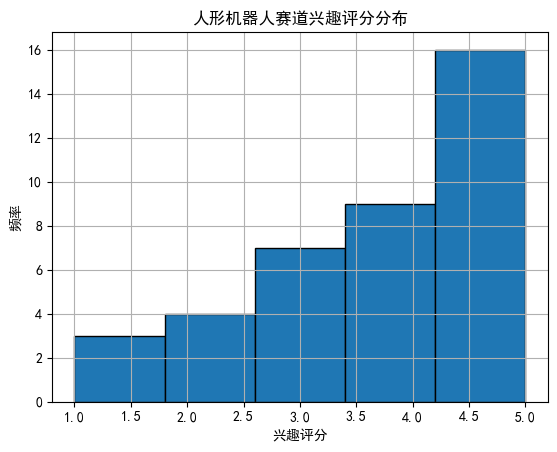

In [46]:
# 2. 对人形机器人赛道的平均兴趣（均值点估计）
print("\n2. 人形机器人赛道的平均兴趣")
import matplotlib.pyplot as plt

# 列名
col = '11、从消费者（而非创业者）的角度，你对以下每个赛道的兴趣程度如何（该领域会出现你希望了解甚至购买的产品吗）？—1.人形机器人'

# 1. 计算平均兴趣评分
humanoid_robot_mean = data[col].mean()
print(f"对人形机器人赛道的平均兴趣评分：{humanoid_robot_mean}")

# 2. 可视化分布
data[col].hist(bins=5, edgecolor='black')
plt.title('人形机器人赛道兴趣评分分布')
plt.xlabel('兴趣评分')
plt.ylabel('频率')
plt.show()



3. 不同创业赛道的平均技术难度
人形机器人 的平均难度评分：4.69
元宇宙 的平均难度评分：4.51
助残 的平均难度评分：3.90
医疗干预 的平均难度评分：3.85
工业机器人相关 的平均难度评分：3.82
移动机器人相关 的平均难度评分：3.79
医疗检测 的平均难度评分：3.56
消费电子 的平均难度评分：3.21
竞技运动 的平均难度评分：3.10
兴趣爱好 的平均难度评分：2.92
养老 的平均难度评分：2.90
教育培训 的平均难度评分：2.87
健康科技 的平均难度评分：2.77
户外休闲 的平均难度评分：2.59
智能家居 的平均难度评分：2.59
宠物经济 的平均难度评分：2.44


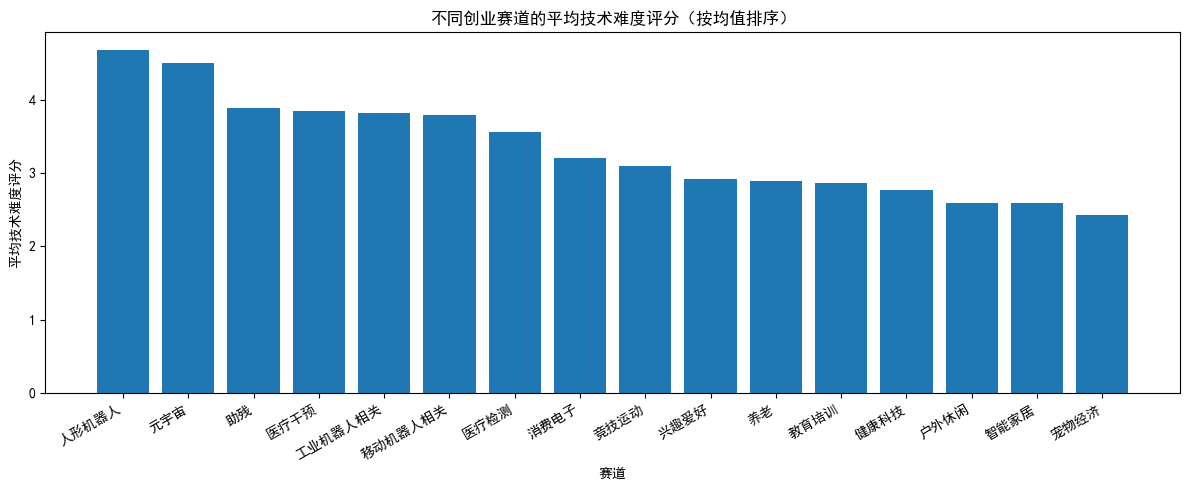

In [47]:
# 3. 不同创业赛道的平均技术难度（均值点估计）
print("\n3. 不同创业赛道的平均技术难度")
# 找出所有“难度”相关的列名（包含“12、”）
difficulty_cols = [col for col in data.columns if "12、" in col]

# 计算每个赛道的平均难度
difficulty_means = {col: data[col].mean() for col in difficulty_cols}

# 对技术难度均值排序（从高到低）
sorted_means = sorted(difficulty_means.items(), key=lambda x: x[1], reverse=True)

# 打印排序结果
for k, v in sorted_means:
    print(f"{clean_label(k)} 的平均难度评分：{v:.2f}")

# 排序后可视化
plt.figure(figsize=(12, 5))
plt.bar(range(len(sorted_means)),
        [v for _, v in sorted_means],
        tick_label=[clean_label(k) for k, _ in sorted_means])
plt.ylabel('平均技术难度评分')
plt.xlabel('赛道')
plt.title('不同创业赛道的平均技术难度评分（按均值排序）')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



4. 各赛道创业意愿均值
各赛道创业意愿均值点估计值：
第1名：人形机器人，创业意愿均值点估计值：3.87
第2名：元宇宙，创业意愿均值点估计值：3.44
第3名：移动机器人相关，创业意愿均值点估计值：3.44
第4名：消费电子，创业意愿均值点估计值：3.33
第5名：智能家居，创业意愿均值点估计值：3.28
第6名：医疗干预，创业意愿均值点估计值：3.21
第7名：户外休闲，创业意愿均值点估计值：3.18
第8名：健康科技，创业意愿均值点估计值：3.18
第9名：工业机器人相关，创业意愿均值点估计值：3.18
第10名：医疗检测，创业意愿均值点估计值：3.10
第11名：竞技运动，创业意愿均值点估计值：3.03
第12名：养老，创业意愿均值点估计值：2.97
第13名：兴趣爱好，创业意愿均值点估计值：2.97
第14名：助残，创业意愿均值点估计值：2.90
第15名：宠物经济，创业意愿均值点估计值：2.79
第16名：教育培训，创业意愿均值点估计值：2.49


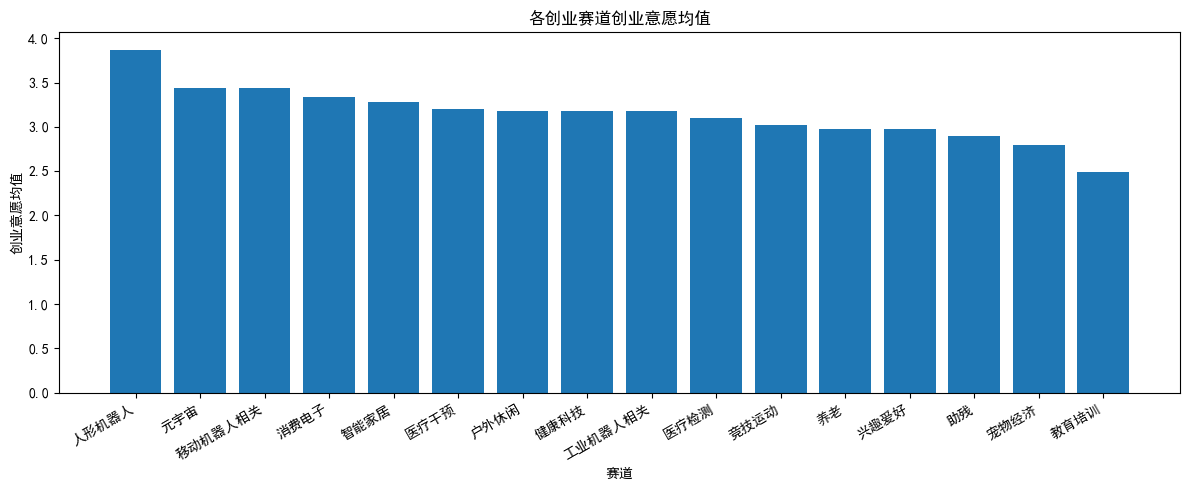

In [48]:
# 4. 各赛道创业意愿均值（均值点估计）
print("\n4. 各赛道创业意愿均值")
willing_means = {}
for col in willing_cols:
    vals = willing_scores[col].dropna()
    mean_est = vals.mean()  # 点估计
    willing_means[col] = mean_est

# 排序，降序输出
willing_means_sorted = dict(sorted(willing_means.items(), key=lambda item: item[1], reverse=True))

print("各赛道创业意愿均值点估计值：")
for rank, (col, mean_est) in enumerate(willing_means_sorted.items(), 1):
    print(f"第{rank}名：{clean_label(col)}，创业意愿均值点估计值：{mean_est:.2f}")

plt.figure(figsize=(12, 5))
plt.bar([clean_label(c) for c in willing_means_sorted.keys()], list(willing_means_sorted.values()))
plt.ylabel('创业意愿均值')
plt.xlabel('赛道')
plt.title('各创业赛道创业意愿均值')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


5. 编程能力与创业赛道选择的相关性（按相关系数降序排序）
编程能力与各赛道兴趣相关系数（按绝对值降序排序）：
助残: 0.32
消费电子: 0.32
元宇宙: 0.26
医疗检测: 0.25
医疗干预: 0.23
移动机器人相关: 0.21
户外休闲: 0.19
工业机器人相关: 0.17
宠物经济: 0.17
兴趣爱好: -0.16
智能家居: -0.14
养老: 0.12
教育培训: -0.11
健康科技: -0.10
人形机器人: 0.08
竞技运动: 0.02
最大绝对相关系数赛道的p值: 0.0479


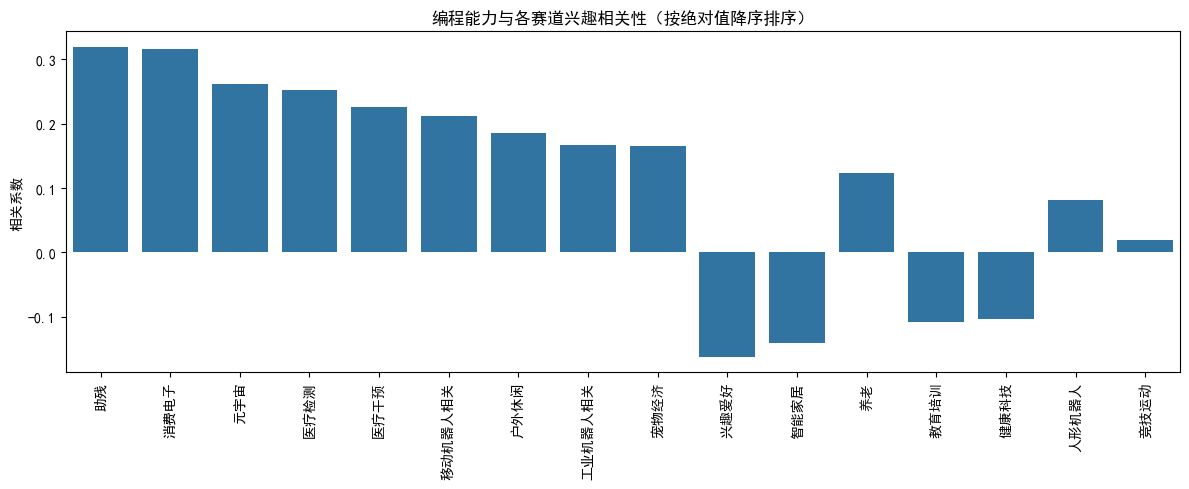

In [50]:
# 5. 编程能力与创业赛道选择的相关性（相关系数点估计）
from scipy.stats import t
print("\n5. 编程能力与创业赛道选择的相关性（按相关系数降序排序）")
coding_bin = (data[coding_col] == 'C.偏强').astype(int)
corrs = []
for col in interest_cols:
    vals = interest_scores[col]
    mask = ~vals.isna()
    if mask.sum() > 0:
        corr = np.corrcoef(coding_bin[mask], vals[mask])[0,1]  # 样本相关系数点估计
    else:
        corr = np.nan
    corrs.append(corr)

# 构建label-相关系数字典并排序（降序）
corrs_dict = {clean_label(c): v for c, v in zip(interest_cols, corrs)}
corrs_sorted = dict(sorted(corrs_dict.items(), key=lambda item: abs(item[1]) if item[1] is not None else -1, reverse=True))

print("编程能力与各赛道兴趣相关系数（按绝对值降序排序）：")
for c, v in corrs_sorted.items():
    print(f"{c}: {v:.2f}")

# 以最大绝对值相关系数赛道的数据计算p值（如需所有赛道p值可循环计算）
max_col = interest_cols[[clean_label(c) for c in interest_cols].index(next(iter(corrs_sorted.keys())))]
vals = interest_scores[max_col]
mask = ~vals.isna()
corr = np.corrcoef(coding_bin[mask], vals[mask])[0,1]
n = mask.sum()
t_stat = corr * np.sqrt((n-2)/(1-corr**2))
p_value = 2 * (1 - t.cdf(abs(t_stat), df=n-2))
print(f"最大绝对相关系数赛道的p值: {p_value:.4f}")

plt.figure(figsize=(12,5))
sns.barplot(x=list(corrs_sorted.keys()), y=list(corrs_sorted.values()))
plt.xticks(rotation=90)
plt.ylabel('相关系数')
plt.title('编程能力与各赛道兴趣相关性（按绝对值降序排序）')
plt.tight_layout(); plt.show()

高技术难度兴趣赛道： ['1.人形机器人', '脑控轮椅等）', '超声检测机器人等）', '触觉反馈手套等）', '无人艇等）', '工业物联网等）']
偏强同学人数： 8
偏强同学在高难度赛道兴趣均值（按兴趣均值降序排序）：
元宇宙: 4.50
移动机器人相关: 4.38
人形机器人: 4.00
医疗干预: 3.88
工业机器人相关: 3.88
助残: 3.62
元宇宙 偏强同学兴趣MLE: 均值=4.50, 标准差=0.71
移动机器人相关 偏强同学兴趣MLE: 均值=4.38, 标准差=0.99
人形机器人 偏强同学兴趣MLE: 均值=4.00, 标准差=1.32
医疗干预 偏强同学兴趣MLE: 均值=3.88, 标准差=0.78
工业机器人相关 偏强同学兴趣MLE: 均值=3.88, 标准差=1.05
助残 偏强同学兴趣MLE: 均值=3.62, 标准差=0.70


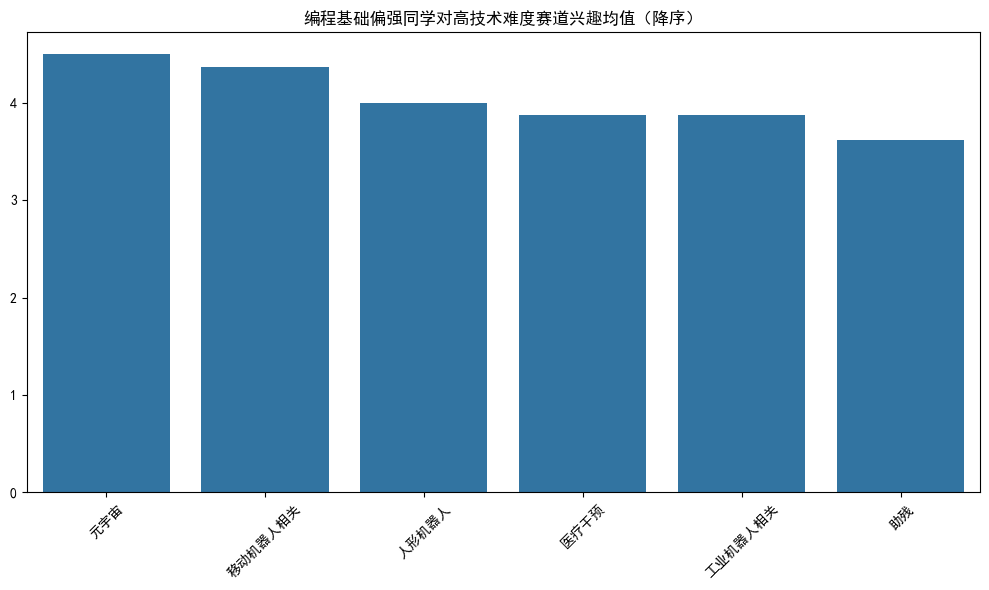

In [51]:
# 6. 编程能力偏强同学在高难度赛道的兴趣（最大似然估计）
def extract_track_name(col):
    # 处理两种常见命名风格
    if '—' in col:
        return col.split('—')[-1].strip()
    elif '、' in col and len(col.split('、')) > 1:
        return col.split('、')[-1].strip()
    else:
        return col.strip()

# 建立映射：赛道名->原列名
difficulty_name2col = {extract_track_name(col): col for col in difficulty_scores.columns}
interest_name2col   = {extract_track_name(col): col for col in interest_scores.columns}

# 计算高难度赛道
mean_difficulties = difficulty_scores.mean()
threshold = mean_difficulties.quantile(2/3)
hard_tracks = mean_difficulties[mean_difficulties >= threshold].index
hard_track_names = [extract_track_name(col) for col in hard_tracks]

# 只保留兴趣表中有的高难度赛道
hard_tracks_interest = [interest_name2col[name] for name in hard_track_names if name in interest_name2col]

print("高技术难度兴趣赛道：", [extract_track_name(c) for c in hard_tracks_interest])

# 只看编程基础偏强同学
strong_mask = data[coding_col] == 'C.偏强'
print("偏强同学人数：", strong_mask.sum())

# 计算兴趣均值并排序
hard_interest_strong = interest_scores.loc[strong_mask, hard_tracks_interest].mean()
hard_interest_strong = hard_interest_strong.sort_values(ascending=False)

print("偏强同学在高难度赛道兴趣均值（按兴趣均值降序排序）：")
for col, val in hard_interest_strong.items():
    print(f"{clean_label(col)}: {val:.2f}")

# 用最大似然估计拟合每个高难度赛道的兴趣分布
for col in hard_interest_strong.index:
    vals = interest_scores.loc[strong_mask, col].dropna()
    if len(vals) == 0:
        print(f"{clean_label(col)} 偏强同学无有效兴趣数据，跳过")
        continue
    mu, std = stats.norm.fit(vals)
    print(f"{clean_label(col)} 偏强同学兴趣MLE: 均值={mu:.2f}, 标准差={std:.2f}")

plt.figure(figsize=(10,6))
plot_data = hard_interest_strong.dropna()
if not plot_data.empty:
    sns.barplot(x=[clean_label(c) for c in plot_data.index], y=plot_data.values)
    plt.title('编程基础偏强同学对高技术难度赛道兴趣均值（降序）')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("无足够有效数据用于绘图！")


7. 性别差异对创业赛道兴趣的影响
人形机器人: 男均值=3.91, 女均值=3.29 | t=1.15, p=0.2585
竞技运动: 男均值=3.16, 女均值=2.71 | t=0.81, p=0.4245
户外休闲: 男均值=3.69, 女均值=3.14 | t=1.15, p=0.2578
健康科技: 男均值=3.91, 女均值=3.43 | t=1.19, p=0.2429
智能家居: 男均值=3.69, 女均值=4.29 | t=-1.34, p=0.1882
宠物经济: 男均值=3.19, 女均值=3.43 | t=-0.47, p=0.6431
养老: 男均值=3.22, 女均值=3.86 | t=-1.26, p=0.2146
助残: 男均值=2.81, 女均值=3.43 | t=-1.32, p=0.1963
教育培训: 男均值=2.59, 女均值=3.43 | t=-1.77, p=0.0855
兴趣爱好: 男均值=3.34, 女均值=3.14 | t=0.49, p=0.6287
医疗检测: 男均值=3.22, 女均值=3.57 | t=-0.69, p=0.4932
医疗干预: 男均值=3.31, 女均值=3.71 | t=-0.86, p=0.3949
元宇宙: 男均值=3.78, 女均值=4.14 | t=-0.67, p=0.5085
消费电子: 男均值=3.84, 女均值=3.86 | t=-0.03, p=0.9764
移动机器人相关: 男均值=3.88, 女均值=4.00 | t=-0.25, p=0.8010
工业机器人相关: 男均值=3.44, 女均值=3.57 | t=-0.25, p=0.8049


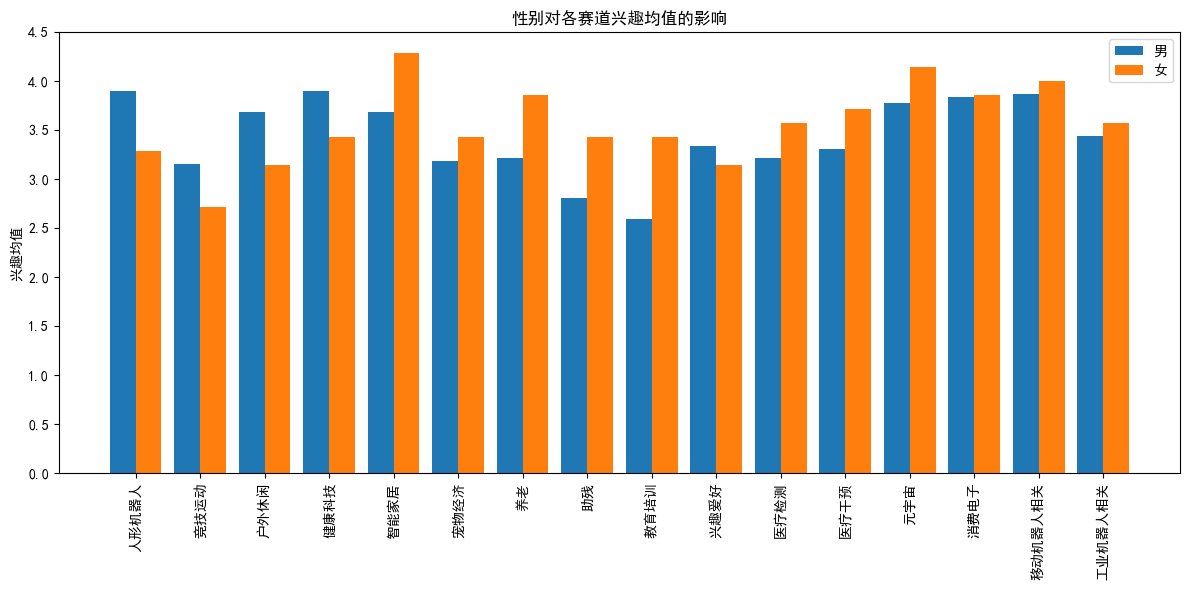

In [52]:
# 7. 性别差异对创业赛道兴趣的影响（均值点估计+分组t检验）

print("\n7. 性别差异对创业赛道兴趣的影响")
male_mask = data[sex_col] == 'A.男'
female_mask = data[sex_col] == 'B.女'
male_interest = interest_scores[male_mask].mean()
female_interest = interest_scores[female_mask].mean()
for col in interest_cols:
    m_vals = interest_scores.loc[male_mask, col].dropna()
    f_vals = interest_scores.loc[female_mask, col].dropna()
    if len(m_vals)==0 or len(f_vals)==0:
        print(f"{clean_label(col)}: 男或女无数据，跳过")
        continue
    mu_m, std_m = stats.norm.fit(m_vals)
    mu_f, std_f = stats.norm.fit(f_vals)
    t, p = stats.ttest_ind(m_vals, f_vals, nan_policy='omit')
    print(f"{clean_label(col)}: 男均值={mu_m:.2f}, 女均值={mu_f:.2f} | t={t:.2f}, p={p:.4f}")
index = range(len(interest_cols))
plt.figure(figsize=(12,6))
plt.bar(index, male_interest, width=0.4, label='男')
plt.bar([i+0.4 for i in index], female_interest, width=0.4, label='女')
plt.xticks([i+0.2 for i in index], [clean_label(c) for c in interest_cols], rotation=90)
plt.ylabel('兴趣均值')
plt.title('性别对各赛道兴趣均值的影响')
plt.legend()
plt.tight_layout(); plt.show()


8. 技术难度对创业意愿的影响
技术难度回归系数的点估计值：0.112
截距项的点估计值：2.773
决定系数R²的点估计值：0.011
回归系数的p值（显著性）：0.0104


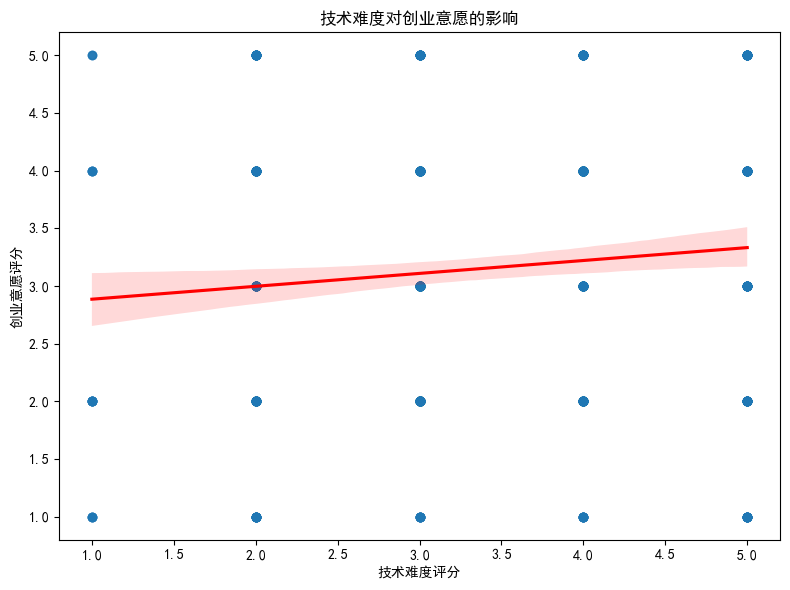

In [54]:
# 8. 技术难度对创业意愿的影响(回归系数的点估计)
print("\n8. 技术难度对创业意愿的影响")

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 准备数据
diff_flat = difficulty_scores.values.flatten()
willing_flat = willing_scores.values.flatten()
mask = (~np.isnan(diff_flat)) & (~np.isnan(willing_flat))

# 用样本数据对总体回归参数进行点估计
X = sm.add_constant(diff_flat[mask])
model = sm.OLS(willing_flat[mask], X).fit()

# ——点估计部分——
# 回归系数的点估计：coef_hat 就是总体真实系数beta的单点最优估计
coef_hat = model.params[1]        # 技术难度回归系数的点估计
intercept_hat = model.params[0]   # 截距的点估计
r2_hat = model.rsquared           # 决定系数的点估计
p_hat = model.pvalues[1]          # 系数显著性的点估计（p值）

print(f"技术难度回归系数的点估计值：{coef_hat:.3f}")
print(f"截距项的点估计值：{intercept_hat:.3f}")
print(f"决定系数R²的点估计值：{r2_hat:.3f}")
print(f"回归系数的p值（显著性）：{p_hat:.4f}")

# 可视化
plt.figure(figsize=(8,6))
sns.regplot(x=diff_flat[mask], y=willing_flat[mask], line_kws={'color':'red'})
plt.xlabel('技术难度评分')
plt.ylabel('创业意愿评分')
plt.title('技术难度对创业意愿的影响')
plt.tight_layout(); plt.show()


9. 社会价值高与商业赛道兴趣差异
社会价值高均值=3.35, 商业赛道均值=3.65 | t=-1.86, p=0.0663


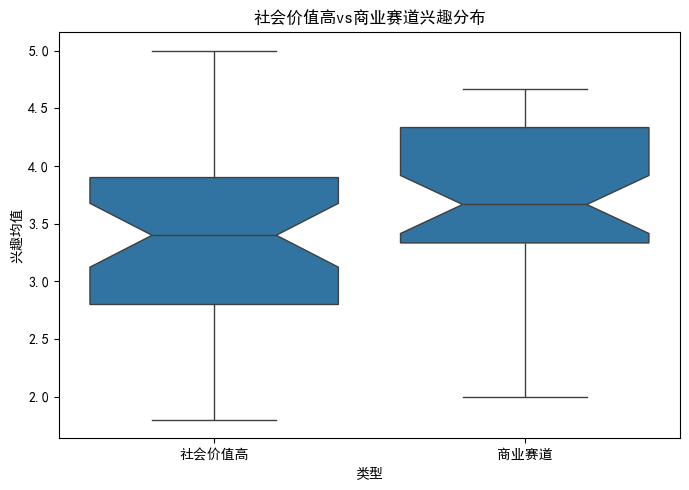

In [55]:
# 9. 社会价值高与商业赛道兴趣差异（均值最大似然估计+t检验）
print("\n9. 社会价值高与商业赛道兴趣差异")
socval_high_cols = [c for c in socval_cols if any(k in c for k in ['健康科技', '助残', '养老', '医疗检测', '医疗干预'])]
business_cols = [c for c in socval_cols if any(k in c for k in ['消费电子', '兴趣爱好', '智能家居'])]
socval_high_interest_cols = [c.replace('14、','11、') for c in socval_high_cols if c.replace('14、','11、') in interest_scores.columns]
business_interest_cols = [c.replace('14、','11、') for c in business_cols if c.replace('14、','11、') in interest_scores.columns]
socval_high_interest = interest_scores[socval_high_interest_cols].mean(axis=1)
business_interest = interest_scores[business_interest_cols].mean(axis=1)
mu1, std1 = stats.norm.fit(socval_high_interest.dropna())
mu2, std2 = stats.norm.fit(business_interest.dropna())
t, p = stats.ttest_ind(socval_high_interest.dropna(), business_interest.dropna())
print(f"社会价值高均值={mu1:.2f}, 商业赛道均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")

df_box = pd.DataFrame({
    '类型': ['社会价值高'] * len(socval_high_interest.dropna()) + ['商业赛道'] * len(business_interest.dropna()),
    '兴趣均值': pd.concat([socval_high_interest.dropna(), business_interest.dropna()], ignore_index=True)
})
plt.figure(figsize=(7,5))
sns.boxplot(x='类型', y='兴趣均值', data=df_box, notch=True)
plt.ylabel('兴趣均值')
plt.title('社会价值高vs商业赛道兴趣分布')
plt.tight_layout()
plt.show()


10. 运动偏好对竞技赛道的兴趣
偏好运动人数：26, 非偏好人数：13
运动偏好均值=3.31, 非偏好均值=2.62 | t=1.59, p=0.1198


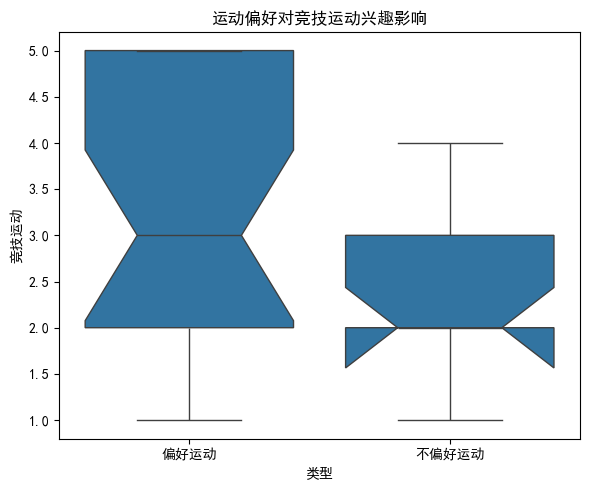

In [56]:
# 10. 运动偏好对竞技赛道的兴趣
print("\n10. 运动偏好对竞技赛道的兴趣")
sport_map = {
    'A.0-1': 0.5,
    'B.1-2': 1.5,
    'C.2-4': 3.0,
    'D.4-8': 6.0,
    'E.8以上': 10.0
}
sport_time = data[sports_col].map(sport_map)
strong_sport = sport_time > 2
sports_interest_col = [c for c in interest_cols if '竞技运动' in c]
if sports_interest_col:
    sports_interest = interest_scores[sports_interest_col[0]]
    group1 = sports_interest[strong_sport].dropna()
    group2 = sports_interest[~strong_sport].dropna()
    print(f"偏好运动人数：{len(group1)}, 非偏好人数：{len(group2)}")
    if len(group1) == 0 or len(group2) == 0:
        print("某组数据为空，无法进行统计和绘图。")
    else:
        mu1, std1 = stats.norm.fit(group1)
        mu2, std2 = stats.norm.fit(group2)
        t, p = stats.ttest_ind(group1, group2)
        print(f"运动偏好均值={mu1:.2f}, 非偏好均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")
        # 绘图
        df_box = pd.DataFrame({
            '类型': ['偏好运动'] * len(group1) + ['不偏好运动'] * len(group2),
            '竞技运动兴趣': pd.concat([group1, group2], ignore_index=True)
        })
        plt.figure(figsize=(6,5))
        sns.boxplot(x='类型', y='竞技运动兴趣', data=df_box, notch=True)
        plt.ylabel(clean_label(sports_interest_col[0]))
        plt.title('运动偏好对竞技运动兴趣影响')
        plt.tight_layout()
        plt.show()
else:
    print("未找到竞技运动兴趣列！")


11. 游戏偏好对竞技赛道的兴趣
偏好游戏人数：36, 非偏好人数：3
游戏偏好均值=3.17, 非偏好均值=2.00 | t=1.51, p=0.1390


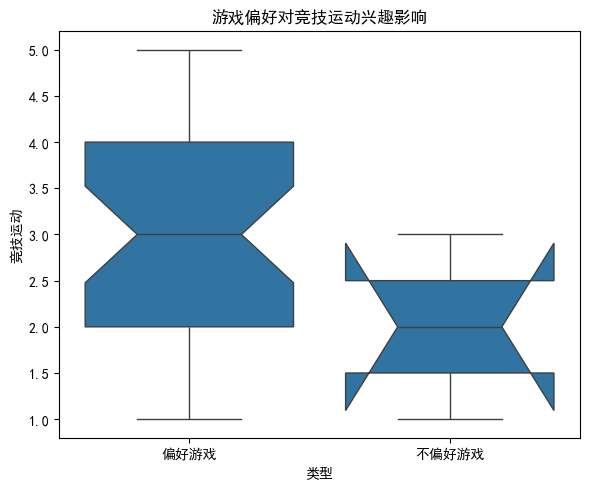

In [57]:
# 11. 游戏偏好对竞技赛道的兴趣
print("\n11. 游戏偏好对竞技赛道的兴趣")
game_map = {
    'A.小于1': 0.5,
    'B.1-4': 2.5,
    'C.3-5': 4.0,
    'D.5-7': 6.0,
    'E.7以上': 8.0
}
game_time = data[games_col].map(game_map)
strong_game = game_time > 2  # 或你想设定的阈值
sports_interest_col = [c for c in interest_cols if '竞技运动' in c]
if sports_interest_col:
    sports_interest = interest_scores[sports_interest_col[0]]
    group1 = sports_interest[strong_game].dropna()
    group2 = sports_interest[~strong_game].dropna()
    print(f"偏好游戏人数：{len(group1)}, 非偏好人数：{len(group2)}")
    if len(group1) == 0 or len(group2) == 0:
        print("某组数据为空，无法进行统计和绘图。")
    else:
        mu1, std1 = stats.norm.fit(group1)
        mu2, std2 = stats.norm.fit(group2)
        t, p = stats.ttest_ind(group1, group2)
        print(f"游戏偏好均值={mu1:.2f}, 非偏好均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")
        # 绘图
        df_box = pd.DataFrame({
            '类型': ['偏好游戏'] * len(group1) + ['不偏好游戏'] * len(group2),
            '竞技运动兴趣': pd.concat([group1, group2], ignore_index=True)
        })
        plt.figure(figsize=(6,5))
        sns.boxplot(x='类型', y='竞技运动兴趣', data=df_box, notch=True)
        plt.ylabel(clean_label(sports_interest_col[0]))
        plt.title('游戏偏好对竞技运动兴趣影响')
        plt.tight_layout()
        plt.show()
else:
    print("未找到竞技运动兴趣列！")


12. 创业热情与赛道选择的关系
人形机器人 高热情均值=4.05, 低热情均值=3.55 | t=1.21, p=0.2328
竞技运动 高热情均值=3.42, 低热情均值=2.75 | t=1.64, p=0.1095
户外休闲 高热情均值=3.89, 低热情均值=3.30 | t=1.67, p=0.1043
健康科技 高热情均值=3.95, 低热情均值=3.70 | t=0.79, p=0.4333
智能家居 高热情均值=3.95, 低热情均值=3.65 | t=0.86, p=0.3975
宠物经济 高热情均值=3.68, 低热情均值=2.80 | t=2.39, p=0.0220
养老 高热情均值=3.63, 低热情均值=3.05 | t=1.51, p=0.1391
助残 高热情均值=3.42, 低热情均值=2.45 | t=2.93, p=0.0058
教育培训 高热情均值=3.32, 低热情均值=2.20 | t=3.38, p=0.0017
兴趣爱好 高热情均值=3.58, 低热情均值=3.05 | t=1.73, p=0.0914
医疗检测 高热情均值=3.53, 低热情均值=3.05 | t=1.23, p=0.2249
医疗干预 高热情均值=3.58, 低热情均值=3.20 | t=1.06, p=0.2948
元宇宙 高热情均值=4.21, 低热情均值=3.50 | t=1.77, p=0.0851
消费电子 高热情均值=4.11, 低热情均值=3.60 | t=1.51, p=0.1406
移动机器人相关 高热情均值=4.00, 低热情均值=3.80 | t=0.53, p=0.5988
工业机器人相关 高热情均值=3.68, 低热情均值=3.25 | t=1.07, p=0.2935


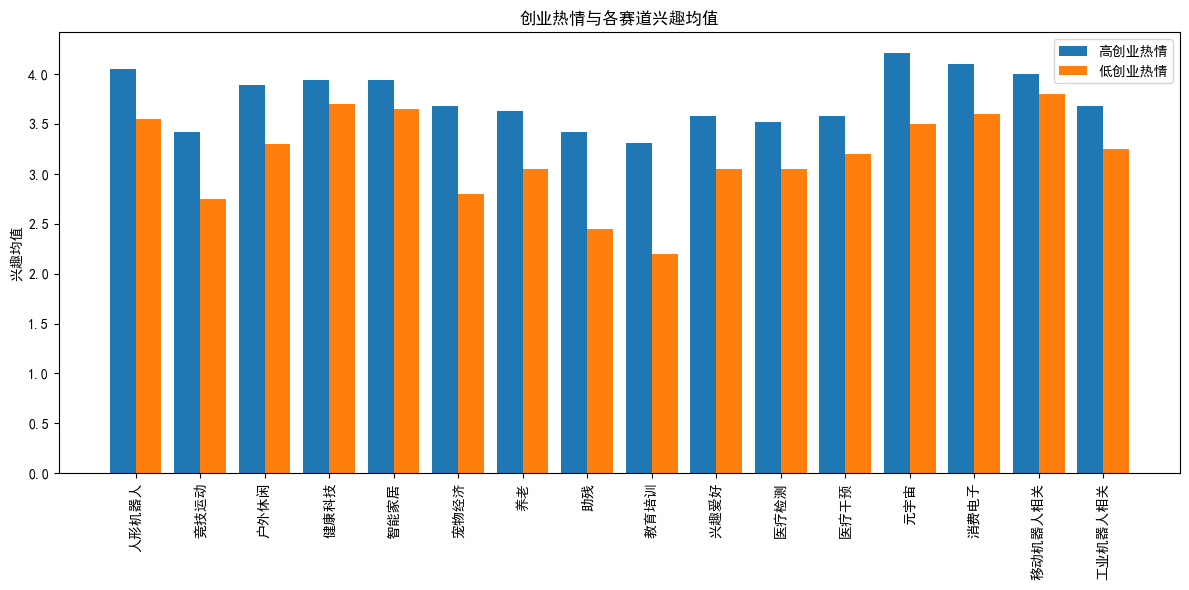

In [59]:
# 12. 创业热情与赛道选择的关系*（均值，标准差点估计）
print("\n12. 创业热情与赛道选择的关系")
mean_willing = willing_scores.mean(axis=1)
high_enthusiasm = mean_willing > mean_willing.median()
for col in interest_cols:
    hi = interest_scores.loc[high_enthusiasm, col].dropna()
    lo = interest_scores.loc[~high_enthusiasm, col].dropna()
    if len(hi)==0 or len(lo)==0:
        print(f"{clean_label(col)}: 高或低热情无数据，跳过")
        continue
    mu1, std1 = stats.norm.fit(hi)
    mu2, std2 = stats.norm.fit(lo)
    t,p = stats.ttest_ind(hi, lo)
    print(f"{clean_label(col)} 高热情均值={mu1:.2f}, 低热情均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")
plt.figure(figsize=(12,6))
high_vals = interest_scores[high_enthusiasm].mean()
low_vals = interest_scores[~high_enthusiasm].mean()
plt.bar(index, high_vals, width=0.4, label='高创业热情')
plt.bar([i+0.4 for i in index], low_vals, width=0.4, label='低创业热情')
plt.xticks([i+0.2 for i in index], [clean_label(c) for c in interest_cols], rotation=90)
plt.ylabel('兴趣均值')
plt.title('创业热情与各赛道兴趣均值')
plt.legend()
plt.tight_layout(); plt.show()



13. 技术难度评分最大似然估计&正态分布检验
所有赛道技术难度分布均值(MLE)=3.34, std=1.07| 正态性p=0.0000 (p>0.05则基本服从正态)


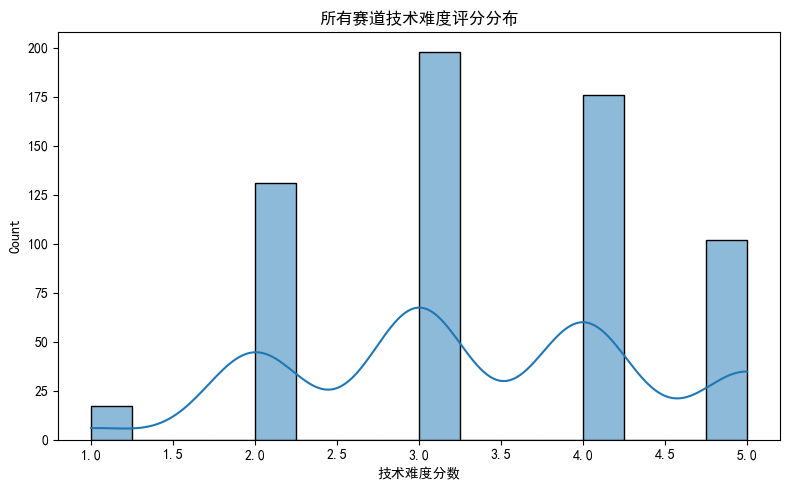

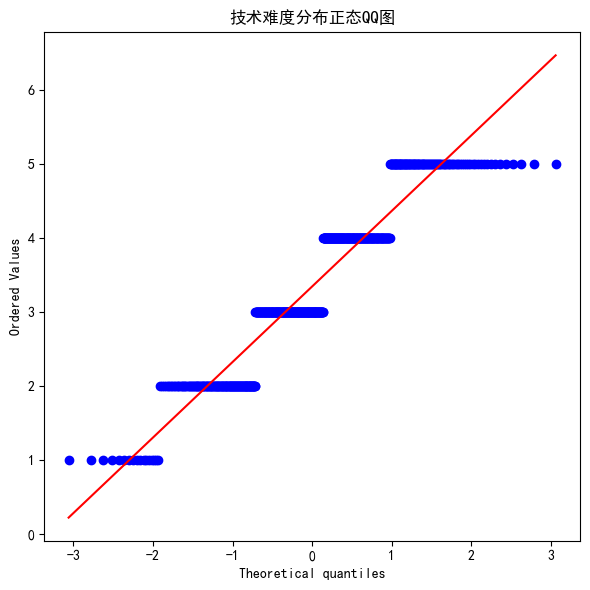

In [61]:
# 13. 技术难度评分（最大似然估计&正态分布检验）
print("\n13. 技术难度评分最大似然估计&正态分布检验")
all_difficulty = difficulty_scores.values.flatten()
all_difficulty = all_difficulty[~np.isnan(all_difficulty)]
mu, std = stats.norm.fit(all_difficulty)
k2, p = stats.normaltest(all_difficulty)
print(f"所有赛道技术难度分布均值(MLE)={mu:.2f}, std={std:.2f}| 正态性p={p:.4f} (p>0.05则基本服从正态)")
plt.figure(figsize=(8,5))
sns.histplot(all_difficulty, bins=16, kde=True)
plt.title('所有赛道技术难度评分分布')
plt.xlabel('技术难度分数')
plt.tight_layout(); plt.show()
plt.figure(figsize=(6,6))
stats.probplot(all_difficulty, dist="norm", plot=plt)
plt.title('技术难度分布正态QQ图')
plt.tight_layout(); plt.show()

高低创业热情同学在消费电子兴趣分布的卡方检验：chi2=3.66, p=0.4536


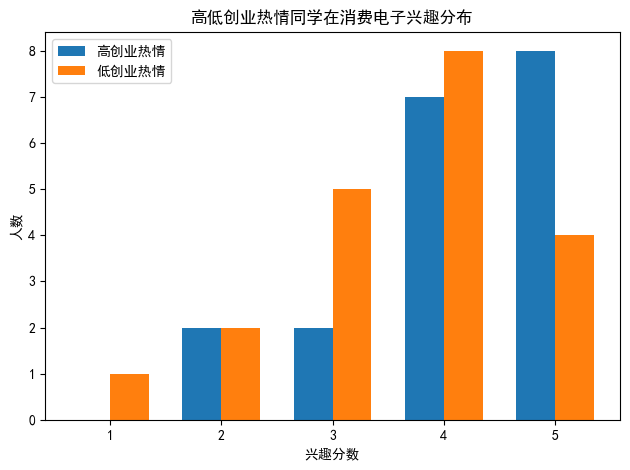

In [69]:
from scipy.stats import chi2_contingency

# 假设 interest_scores, willing_scores 已定义
col = '11、14.消费电子（如随身AI胸针、智能戒指等）'
mean_willing = willing_scores.mean(axis=1)
high_enthusiasm = mean_willing > mean_willing.median()

interest_high = interest_scores.loc[high_enthusiasm, col].dropna().astype(int)
interest_low = interest_scores.loc[~high_enthusiasm, col].dropna().astype(int)

levels = sorted(set(interest_high) | set(interest_low))
contingency = np.array([
    [(interest_high == lvl).sum() for lvl in levels],
    [(interest_low == lvl).sum() for lvl in levels]
])

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"高低创业热情同学在消费电子兴趣分布的卡方检验：chi2={chi2:.2f}, p={p:.4f}")

# 可视化
bar_width = 0.35
index = np.arange(len(levels))
plt.bar(index, contingency[0], bar_width, label='高创业热情')
plt.bar(index + bar_width, contingency[1], bar_width, label='低创业热情')
plt.xlabel('兴趣分数')
plt.ylabel('人数')
plt.title('高低创业热情同学在消费电子兴趣分布')
plt.xticks(index + bar_width / 2, levels)
plt.legend()
plt.tight_layout()
plt.show()

养老兴趣分布正态性：chi2=0.42, p=0.9357


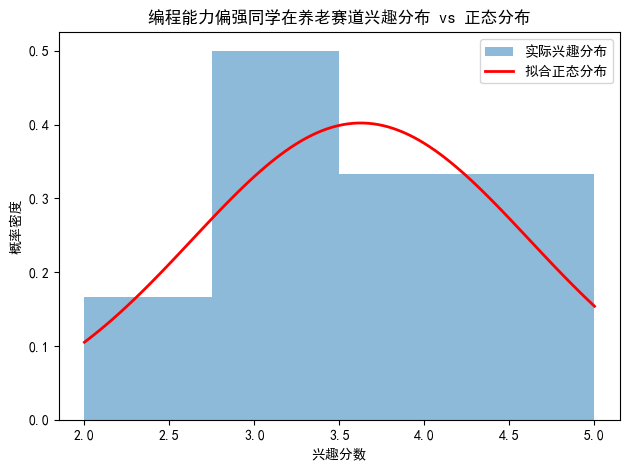

In [71]:
from scipy.stats import norm, chisquare

# 假定 strong_mask, interest_scores, col 已定义
vals = interest_scores.loc[strong_mask, col].dropna().values

mu, sigma = norm.fit(vals)
bins = np.histogram_bin_edges(vals, bins='auto')
obs_counts, _ = np.histogram(vals, bins=bins)
cdf = norm.cdf(bins, loc=mu, scale=sigma)
expected_counts = len(vals) * np.diff(cdf)

# 修正，使总和一致
expected_counts *= obs_counts.sum() / expected_counts.sum()

chi2_stat, p_value = chisquare(f_obs=obs_counts, f_exp=expected_counts)
print(f"养老兴趣分布正态性：chi2={chi2_stat:.2f}, p={p_value:.4f}")

plt.hist(vals, bins=bins, alpha=0.5, label='实际兴趣分布', density=True)
x = np.linspace(min(vals), max(vals), 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2, label='拟合正态分布')
plt.xlabel('兴趣分数')
plt.ylabel('概率密度')
plt.title('编程能力偏强同学在养老赛道兴趣分布 vs 正态分布')
plt.legend()
plt.tight_layout()
plt.show()